In [1]:
#from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit.library import MCMT
from qiskit.circuit.library import MCXGate
from qiskit.circuit.library.standard_gates import SGate, TGate
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2, FakeAuckland, FakeWashingtonV2, FakeCambridgeV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
from itertools import product

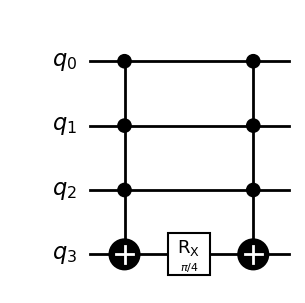

In [2]:
gate = QuantumCircuit(4)
mcx_gate = MCXGate(3)
# Apply the MCX gate on qubits 0, 1, 2 (controls) and 3 (target)
gate.append(mcx_gate, [0, 1, 2, 3])
gate.rx(np.pi/4,3)
gate.append(mcx_gate, [0, 1, 2, 3])
gate.draw('mpl',style='bw')

### Decomposed Circuit

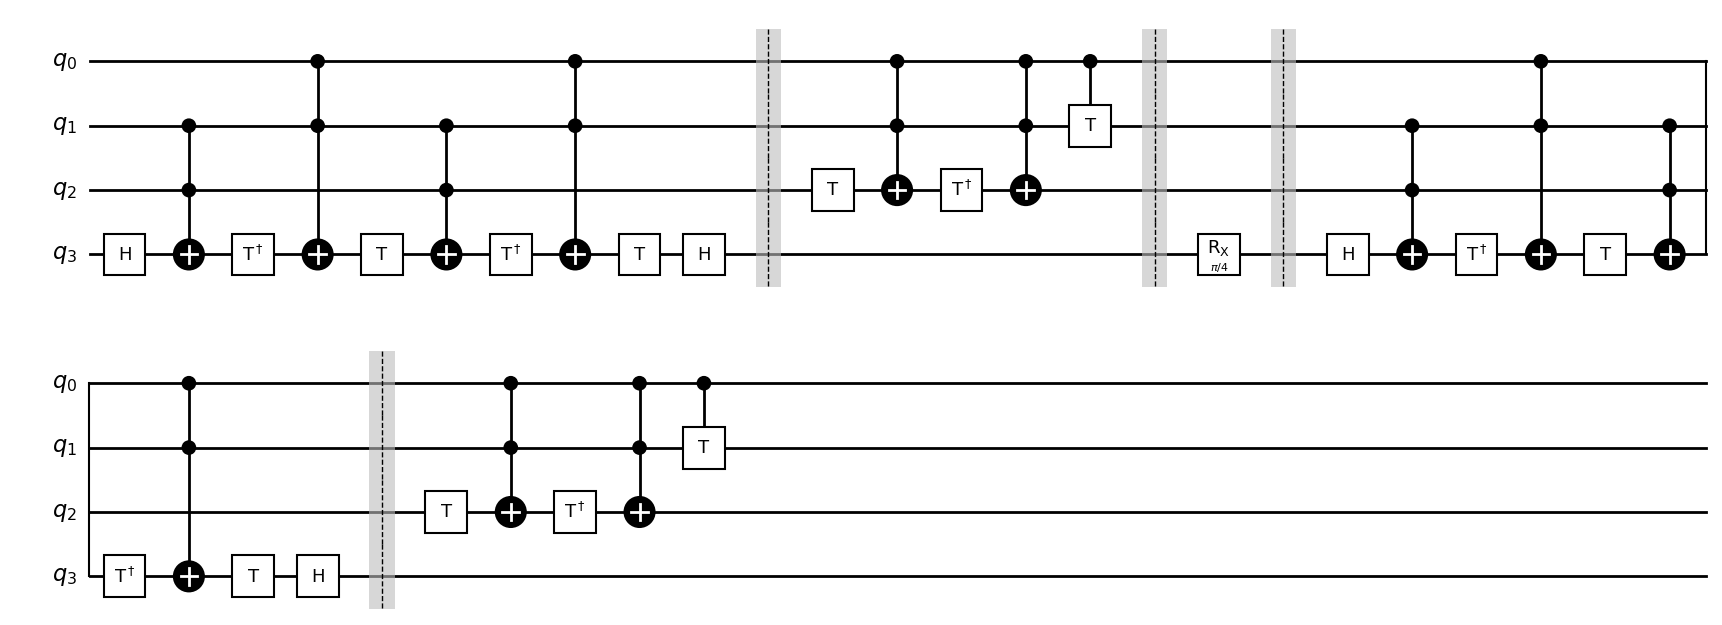

In [4]:
od = QuantumCircuit(4)

od.h(3)
od.ccx(1,2,3)
od.tdg(3)
od.ccx(0,1,3)
od.t(3)
od.ccx(1,2,3)
od.tdg(3)
od.ccx(0,1,3)
od.t(3)
od.h(3)
od.barrier()

od.t(2)
od.ccx(0,1,2)
od.tdg(2)
od.ccx(0,1,2)


csgate = TGate().control(1)
od.append(csgate, [0, 1])
od.barrier()
od.rx(np.pi/4,3)
od.barrier()

od.h(3)
od.ccx(1,2,3)
od.tdg(3)
od.ccx(0,1,3)
od.t(3)
od.ccx(1,2,3)
od.tdg(3)
od.ccx(0,1,3)
od.t(3)
od.h(3)
od.barrier()

od.t(2)
od.ccx(0,1,2)
od.tdg(2)
od.ccx(0,1,2)


csgate = TGate().control(1)
od.append(csgate, [0, 1])

od.draw('mpl', style='bw')

### Simplified Circuit

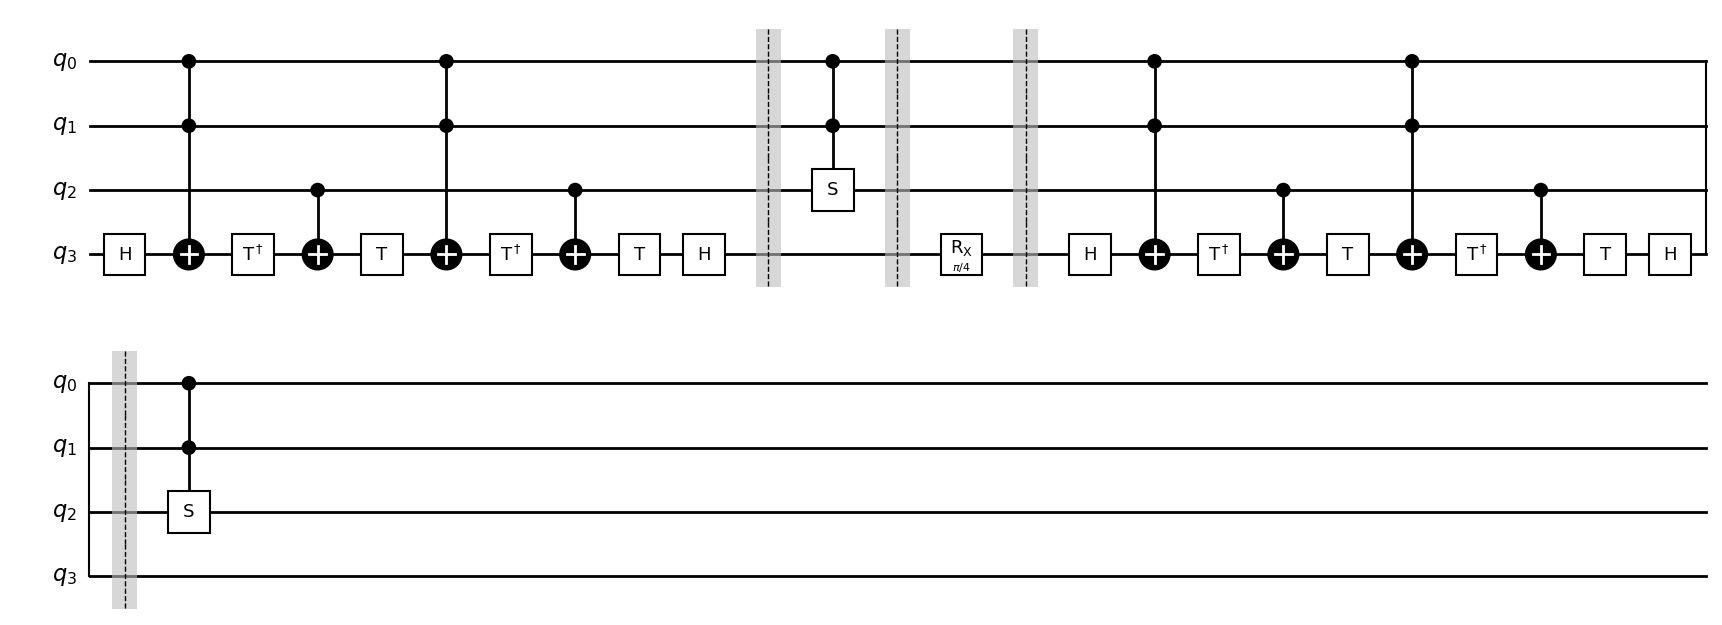

In [6]:
os = QuantumCircuit(4)

os.h(3)
os.ccx(0, 1, 3)
os.tdg(3)
os.cx(2,3)
os.t(3)
os.ccx(0, 1, 3)
os.tdg(3)
os.cx(2,3)
os.t(3)
os.h(3)
os.barrier()


csgate = SGate().control(2)
os.append(csgate, [0, 1, 2])

os.barrier()
os.rx(np.pi/4,3)
os.barrier()

os.h(3)
os.ccx(0, 1, 3)
os.tdg(3)
os.cx(2,3)
os.t(3)
os.ccx(0, 1, 3)
os.tdg(3)
os.cx(2,3)
os.t(3)
os.h(3)
os.barrier()


csgate = SGate().control(2)
os.append(csgate, [0, 1, 2])


os.draw('mpl',style='bw')


### Validity test

In [8]:
from qiskit.quantum_info import Operator
Op1 = Operator(gate)
Op2 = Operator(od)
Op3 = Operator(os)


print("Analysis Before simplification")
print(od.count_ops())
print("Circuit Depth = ", od.depth())


print("Analysis after simplification")
print(os.count_ops())
print("Circuit Depth = ", os.depth())


print("Test for Validity:")
print("Decomposed Circuit: ", Op1.equiv(Op2))
print("Simplified Circuit:", Op1.equiv(Op3))

Analysis Before simplification
OrderedDict({'ccx': 12, 'tdg': 6, 't': 6, 'h': 4, 'barrier': 4, 'ct': 2, 'rx': 1})
Circuit Depth =  31
Analysis after simplification
OrderedDict({'h': 4, 'ccx': 4, 'tdg': 4, 'cx': 4, 't': 4, 'barrier': 4, 'ccs': 2, 'rx': 1})
Circuit Depth =  23
Test for Validity:
Decomposed Circuit:  True
Simplified Circuit: True


### Transpilation Analysis

#### Single Gate

[73, 43, 35, 35]
[120, 78, 105, 105]
[96, 70, 83, 83]


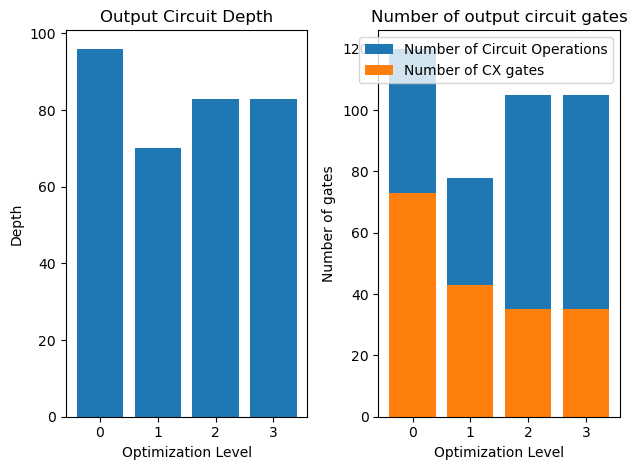

In [11]:
backend = FakeWashingtonV2()
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
    )
    circ = pass_manager.run(gate)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
fig.savefig("c3rx/ogtranspile.png", dpi=300)
print(multiqubit_gate_counts)
print(gate_counts)
print(depths)
plt.show()

#### Original Decomposition

[193, 159, 147, 147]
[404, 308, 342, 342]
[310, 247, 252, 252]


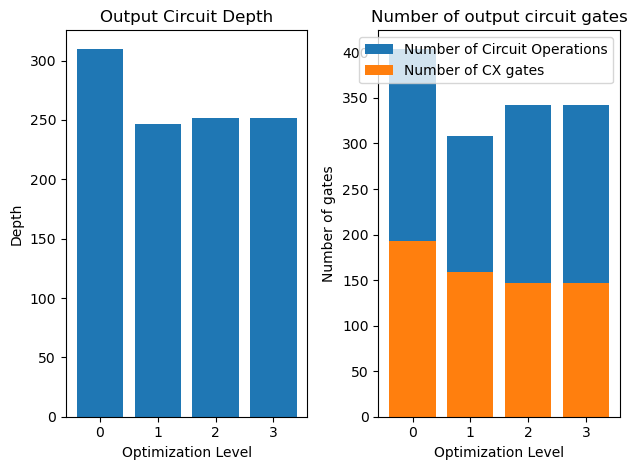

In [13]:
backend = FakeWashingtonV2()
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
    )
    circ = pass_manager.run(od)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
fig.savefig("c3rx/dctranspile.png", dpi=300)
print(multiqubit_gate_counts)
print(gate_counts)
print(depths)
plt.show()

#### QKM Decomposition

[106, 100, 77, 75]
[233, 171, 155, 162]
[172, 136, 131, 131]


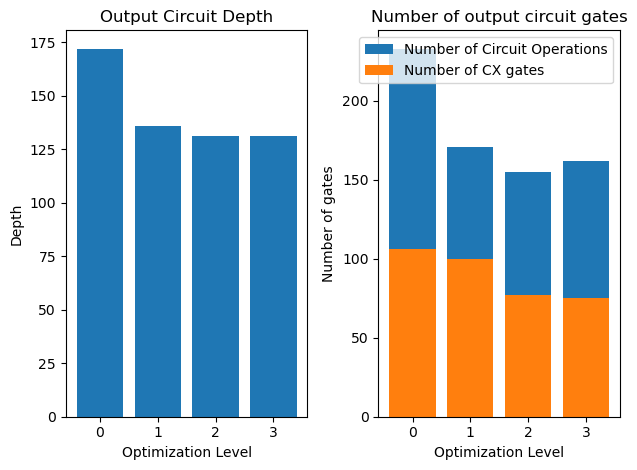

In [15]:
backend = FakeWashingtonV2()
depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
    )
    circ = pass_manager.run(os)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])
 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
fig.savefig("c3rx/sptranspile.png", dpi=300)

print(multiqubit_gate_counts)
print(gate_counts)
print(depths)
plt.show()

### Error Analysis

In [17]:
pauli_operators = ["I", "Z", "X"]

# Generate all combinations for 4 qubits using only I, Z, and X
observables_labels = [''.join(label) for label in product(pauli_operators, repeat=4)]

# Create SparsePauliOp instances for each label
observables = [SparsePauliOp(label) for label in observables_labels]

#### Optimization Level 1

In [19]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2, FakeAuckland, FakeWashingtonV2, FakeCambridgeV2
backend = FakeCambridgeV2()
estimator = Estimator(backend)


  # Convert to an ISA circuit and layout-mapped observables.

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(gate)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_resultg = job.result()[0]
valuesg = pub_resultg.data.evs
errorsg = pub_resultg.data.stds
errors_stdg = 0.001 * np.ones(len(errorsg))


pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(od)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_resultd = job.result()[0]
valuesd = pub_resultd.data.evs
errorsd = pub_resultd.data.stds
errors_stdd = 0.001 * np.ones(len(errorsd))

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(os)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_results = job.result()[0]
valuess = pub_results.data.evs
errorss = pub_results.data.stds
errors_stds = 0.001 * np.ones(len(errorss))

mae_errorss = np.mean(np.abs(errorss))
mae_errorsd = np.mean(np.abs(errorsd))
mae_errorsg = np.mean(np.abs(errorsg))

mae_std_errorss = np.std(np.abs(errorss))
mae_std_errorsd = np.std(np.abs(errorsd))
mae_std_errorsg = np.std(np.abs(errorsg))

# Calculate MSE and its interval
mse_errorss = np.mean(errorss**2)
mse_errorsd = np.mean(errorsd**2)
mse_errorsg = np.mean(errorsg**2)

mse_std_errorss = np.std(errorss**2)
mse_std_errorsd = np.std(errorsd**2)
mse_std_errorsg = np.std(errorsg**2)

# Calculate RMSE and its interval
rmse_errorss = np.sqrt(mse_errorss)
rmse_errorsd = np.sqrt(mse_errorsd)
rmse_errorsg = np.sqrt(mse_errorsg)

rmse_std_errorss = np.std(np.sqrt(errorss**2))
rmse_std_errorsd = np.std(np.sqrt(errorsd**2))
rmse_std_errorsg = np.std(np.sqrt(errorsg**2))

# Print results with ± intervals
print(f"MAE of errorss: {mae_errorss:.7f} ± {mae_std_errorss:.7f}")
print(f"MSE of errorss: {mse_errorss:.7f} ± {mse_std_errorss:.7f}")
print(f"RMSE of errorss: {rmse_errorss:.7f} ± {rmse_std_errorss:.7f}")

print(f"MAE of errorsd: {mae_errorsd:.7f} ± {mae_std_errorsd:.7f}")
print(f"MSE of errorsd: {mse_errorsd:.7f} ± {mse_std_errorsd:.7f}")
print(f"RMSE of errorsd: {rmse_errorsd:.7f} ± {rmse_std_errorsd:.7f}")

print(f"MAE of errorsg: {mae_errorsg:.7f} ± {mae_std_errorsg:.7f}")
print(f"MSE of errorsg: {mse_errorsg:.7f} ± {mse_std_errorsg:.7f}")
print(f"RMSE of errorsg: {rmse_errorsg:.7f} ± {rmse_std_errorsg:.7f}")

MAE of errorss: 0.0152257 ± 0.0017980
MSE of errorss: 0.0002351 ± 0.0000311
RMSE of errorss: 0.0153314 ± 0.0017980
MAE of errorsd: 0.0153346 ± 0.0017473
MSE of errorsd: 0.0002382 ± 0.0000284
RMSE of errorsd: 0.0154338 ± 0.0017473
MAE of errorsg: 0.0151888 ± 0.0018613
MSE of errorsg: 0.0002342 ± 0.0000335
RMSE of errorsg: 0.0153024 ± 0.0018613


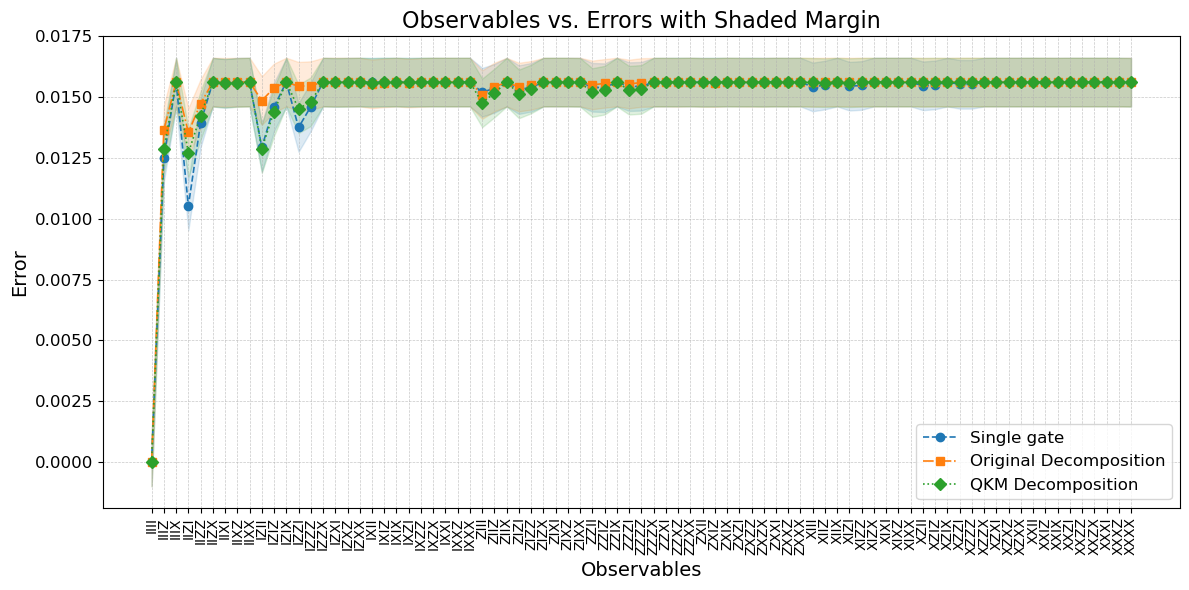

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Larger size for publication

# Plot each set of errors with distinct colors, markers, and line styles
plt.plot(observables_labels, errorsg, 'o--', color='#1f77b4', markersize=6, linewidth=1.2, label='Single gate')
plt.plot(observables_labels, errorsd, 's-.', color='#ff7f0e', markersize=6, linewidth=1.2, label='Original Decomposition')
plt.plot(observables_labels, errorss, 'D:', color='#2ca02c', markersize=6, linewidth=1.2, label='QKM Decomposition')

# Add shaded area (fill between for margin)
plt.fill_between(observables_labels, errorsg - errors_stdg, errorsg + errors_stdg, color='#1f77b4', alpha=0.15)
plt.fill_between(observables_labels, errorsd - errors_stdd, errorsd + errors_stdd, color='#ff7f0e', alpha=0.15)
plt.fill_between(observables_labels, errorss - errors_stds, errorss + errors_stds, color='#2ca02c', alpha=0.15)

# Styling for publication
plt.xlabel('Observables', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Observables vs. Errors with Shaded Margin', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig("c3rx/erro1.png", dpi=300)


# Show the plot
plt.show()


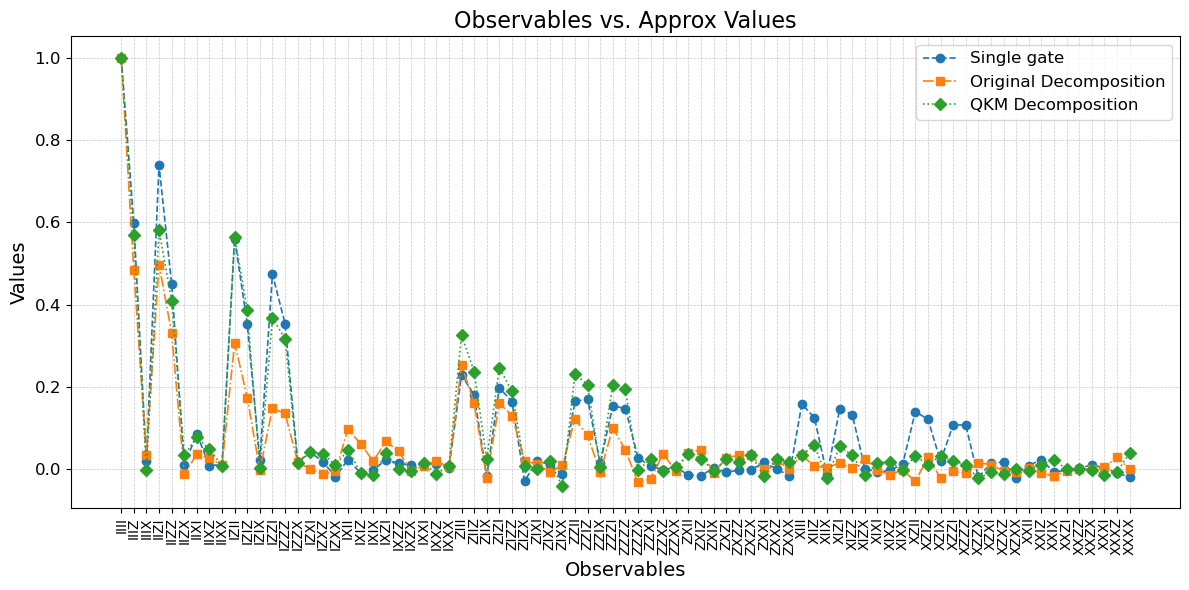

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Larger size for publication

# Plot each set of errors with distinct colors, markers, and line styles
plt.plot(observables_labels, valuesg, 'o--', color='#1f77b4', markersize=6, linewidth=1.2, label='Single gate')
plt.plot(observables_labels, valuesd, 's-.', color='#ff7f0e', markersize=6, linewidth=1.2, label='Original Decomposition')
plt.plot(observables_labels, valuess, 'D:', color='#2ca02c', markersize=6, linewidth=1.2, label='QKM Decomposition')


# Styling for publication
plt.xlabel('Observables', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Observables vs. Approx Values', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig("c3rx/val1.png", dpi=300)

# Show the plot
plt.show()


#### Optimization Level 2

In [23]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2, FakeAuckland, FakeWashingtonV2, FakeCambridgeV2
backend = FakeCambridgeV2()
estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(gate)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_resultg = job.result()[0]
valuesg = pub_resultg.data.evs
errorsg = pub_resultg.data.stds
errors_stdg = 0.001 * np.ones(len(errorsg))


pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(od)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_resultd = job.result()[0]
valuesd = pub_resultd.data.evs
errorsd = pub_resultd.data.stds
errors_stdd = 0.001 * np.ones(len(errorsd))

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(os)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_results = job.result()[0]
valuess = pub_results.data.evs
errorss = pub_results.data.stds
errors_stds = 0.001 * np.ones(len(errorss))

mae_errorss = np.mean(np.abs(errorss))
mae_errorsd = np.mean(np.abs(errorsd))
mae_errorsg = np.mean(np.abs(errorsg))

mae_std_errorss = np.std(np.abs(errorss))
mae_std_errorsd = np.std(np.abs(errorsd))
mae_std_errorsg = np.std(np.abs(errorsg))

# Calculate MSE and its interval
mse_errorss = np.mean(errorss**2)
mse_errorsd = np.mean(errorsd**2)
mse_errorsg = np.mean(errorsg**2)

mse_std_errorss = np.std(errorss**2)
mse_std_errorsd = np.std(errorsd**2)
mse_std_errorsg = np.std(errorsg**2)

# Calculate RMSE and its interval
rmse_errorss = np.sqrt(mse_errorss)
rmse_errorsd = np.sqrt(mse_errorsd)
rmse_errorsg = np.sqrt(mse_errorsg)

rmse_std_errorss = np.std(np.sqrt(errorss**2))
rmse_std_errorsd = np.std(np.sqrt(errorsd**2))
rmse_std_errorsg = np.std(np.sqrt(errorsg**2))

# Print results with ± intervals
print(f"MAE of errorss: {mae_errorss:.7f} ± {mae_std_errorss:.7f}")
print(f"MSE of errorss: {mse_errorss:.7f} ± {mse_std_errorss:.7f}")
print(f"RMSE of errorss: {rmse_errorss:.7f} ± {rmse_std_errorss:.7f}")

print(f"MAE of errorsd: {mae_errorsd:.7f} ± {mae_std_errorsd:.7f}")
print(f"MSE of errorsd: {mse_errorsd:.7f} ± {mse_std_errorsd:.7f}")
print(f"RMSE of errorsd: {rmse_errorsd:.7f} ± {rmse_std_errorsd:.7f}")

print(f"MAE of errorsg: {mae_errorsg:.7f} ± {mae_std_errorsg:.7f}")
print(f"MSE of errorsg: {mse_errorsg:.7f} ± {mse_std_errorsg:.7f}")
print(f"RMSE of errorsg: {rmse_errorsg:.7f} ± {rmse_std_errorsg:.7f}")

MAE of errorss: 0.0151136 ± 0.0018959
MSE of errorss: 0.0002320 ± 0.0000351
RMSE of errorss: 0.0152320 ± 0.0018959
MAE of errorsd: 0.0153544 ± 0.0017374
MSE of errorsd: 0.0002388 ± 0.0000279
RMSE of errorsd: 0.0154524 ± 0.0017374
MAE of errorsg: 0.0149961 ± 0.0020776
MSE of errorsg: 0.0002292 ± 0.0000410
RMSE of errorsg: 0.0151393 ± 0.0020776


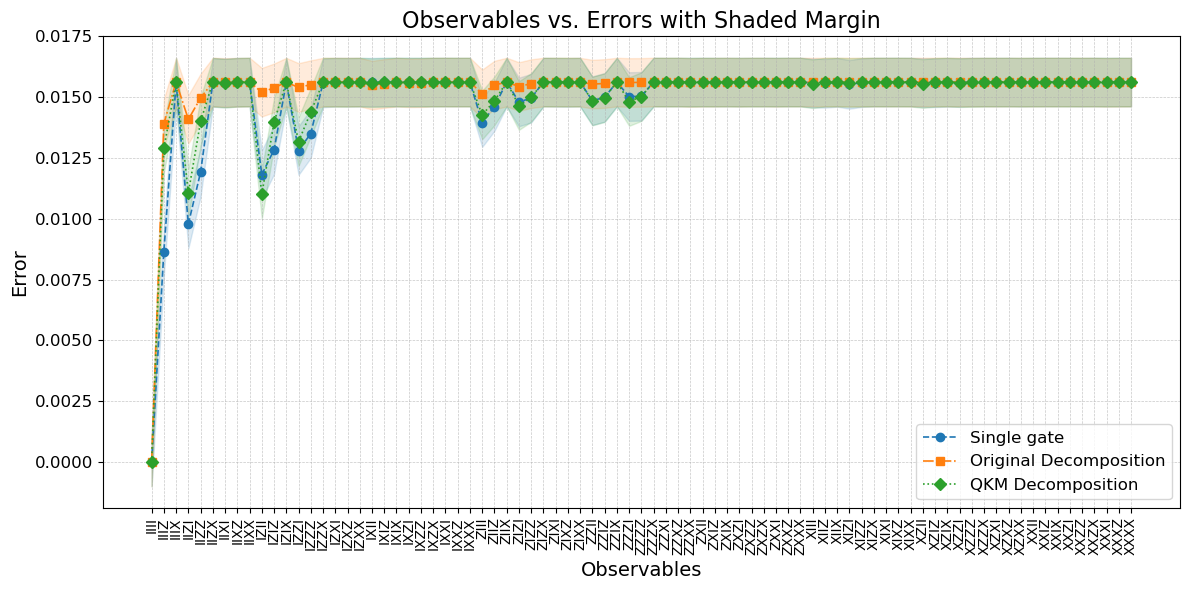

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Larger size for publication

# Plot each set of errors with distinct colors, markers, and line styles
plt.plot(observables_labels, errorsg, 'o--', color='#1f77b4', markersize=6, linewidth=1.2, label='Single gate')
plt.plot(observables_labels, errorsd, 's-.', color='#ff7f0e', markersize=6, linewidth=1.2, label='Original Decomposition')
plt.plot(observables_labels, errorss, 'D:', color='#2ca02c', markersize=6, linewidth=1.2, label='QKM Decomposition')

# Add shaded area (fill between for margin)
plt.fill_between(observables_labels, errorsg - errors_stdg, errorsg + errors_stdg, color='#1f77b4', alpha=0.15)
plt.fill_between(observables_labels, errorsd - errors_stdd, errorsd + errors_stdd, color='#ff7f0e', alpha=0.15)
plt.fill_between(observables_labels, errorss - errors_stds, errorss + errors_stds, color='#2ca02c', alpha=0.15)

# Styling for publication
plt.xlabel('Observables', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Observables vs. Errors with Shaded Margin', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig("c3rx/erro2.png", dpi=300)


# Show the plot
plt.show()

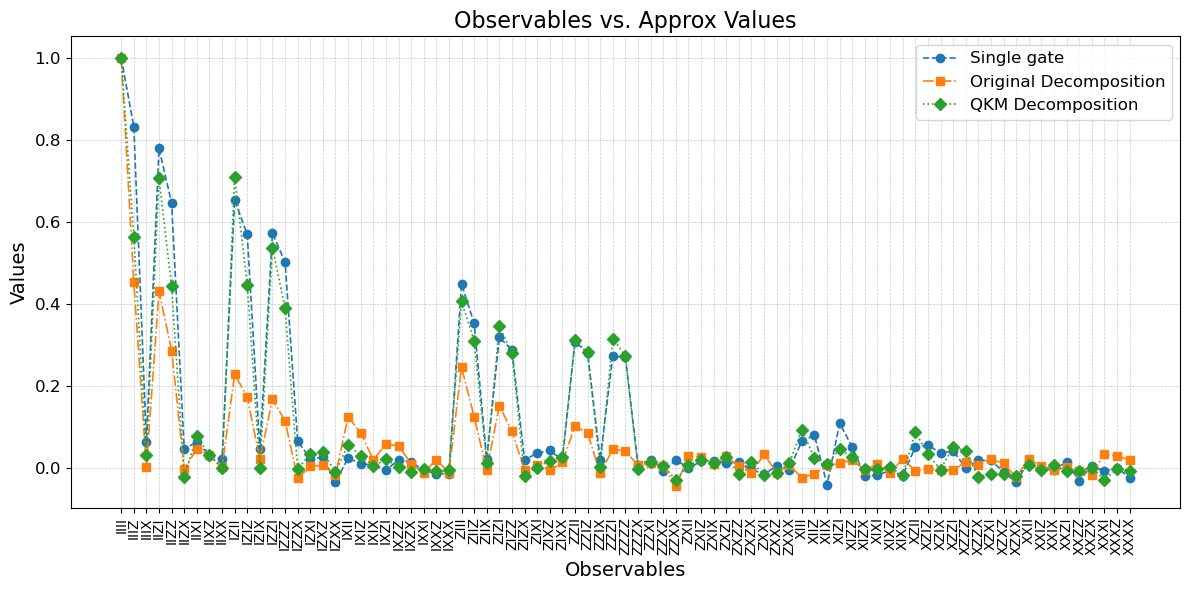

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Larger size for publication

# Plot each set of errors with distinct colors, markers, and line styles
plt.plot(observables_labels, valuesg, 'o--', color='#1f77b4', markersize=6, linewidth=1.2, label='Single gate')
plt.plot(observables_labels, valuesd, 's-.', color='#ff7f0e', markersize=6, linewidth=1.2, label='Original Decomposition')
plt.plot(observables_labels, valuess, 'D:', color='#2ca02c', markersize=6, linewidth=1.2, label='QKM Decomposition')


# Styling for publication
plt.xlabel('Observables', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Observables vs. Approx Values', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig("c3rx/val2.png", dpi=300)

# Show the plot
plt.show()

#### Optimization Level 3

In [27]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2, FakeAuckland, FakeWashingtonV2, FakeCambridgeV2
backend = FakeCambridgeV2()
estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(gate)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_resultg = job.result()[0]
valuesg = pub_resultg.data.evs
errorsg = pub_resultg.data.stds
errors_stdg = 0.001 * np.ones(len(errorsg))


pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(od)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_resultd = job.result()[0]
valuesd = pub_resultd.data.evs
errorsd = pub_resultd.data.stds
errors_stdd = 0.001 * np.ones(len(errorsd))

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(os)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
job_result = job.result()
pub_results = job.result()[0]
valuess = pub_results.data.evs
errorss = pub_results.data.stds
errors_stds = 0.001 * np.ones(len(errorss))

mae_errorss = np.mean(np.abs(errorss))
mae_errorsd = np.mean(np.abs(errorsd))
mae_errorsg = np.mean(np.abs(errorsg))

mae_std_errorss = np.std(np.abs(errorss))
mae_std_errorsd = np.std(np.abs(errorsd))
mae_std_errorsg = np.std(np.abs(errorsg))

# Calculate MSE and its interval
mse_errorss = np.mean(errorss**2)
mse_errorsd = np.mean(errorsd**2)
mse_errorsg = np.mean(errorsg**2)

mse_std_errorss = np.std(errorss**2)
mse_std_errorsd = np.std(errorsd**2)
mse_std_errorsg = np.std(errorsg**2)

# Calculate RMSE and its interval
rmse_errorss = np.sqrt(mse_errorss)
rmse_errorsd = np.sqrt(mse_errorsd)
rmse_errorsg = np.sqrt(mse_errorsg)

rmse_std_errorss = np.std(np.sqrt(errorss**2))
rmse_std_errorsd = np.std(np.sqrt(errorsd**2))
rmse_std_errorsg = np.std(np.sqrt(errorsg**2))

# Print results with ± intervals
print(f"MAE of errorss: {mae_errorss:.7f} ± {mae_std_errorss:.7f}")
print(f"MSE of errorss: {mse_errorss:.7f} ± {mse_std_errorss:.7f}")
print(f"RMSE of errorss: {rmse_errorss:.7f} ± {rmse_std_errorss:.7f}")

print(f"MAE of errorsd: {mae_errorsd:.7f} ± {mae_std_errorsd:.7f}")
print(f"MSE of errorsd: {mse_errorsd:.7f} ± {mse_std_errorsd:.7f}")
print(f"RMSE of errorsd: {rmse_errorsd:.7f} ± {rmse_std_errorsd:.7f}")

print(f"MAE of errorsg: {mae_errorsg:.7f} ± {mae_std_errorsg:.7f}")
print(f"MSE of errorsg: {mse_errorsg:.7f} ± {mse_std_errorsg:.7f}")
print(f"RMSE of errorsg: {rmse_errorsg:.7f} ± {rmse_std_errorsg:.7f}")

MAE of errorss: 0.0151644 ± 0.0018347
MSE of errorss: 0.0002333 ± 0.0000328
RMSE of errorss: 0.0152750 ± 0.0018347
MAE of errorsd: 0.0153602 ± 0.0017352
MSE of errorsd: 0.0002389 ± 0.0000277
RMSE of errorsd: 0.0154579 ± 0.0017352
MAE of errorsg: 0.0150272 ± 0.0021045
MSE of errorsg: 0.0002302 ± 0.0000407
RMSE of errorsg: 0.0151738 ± 0.0021045


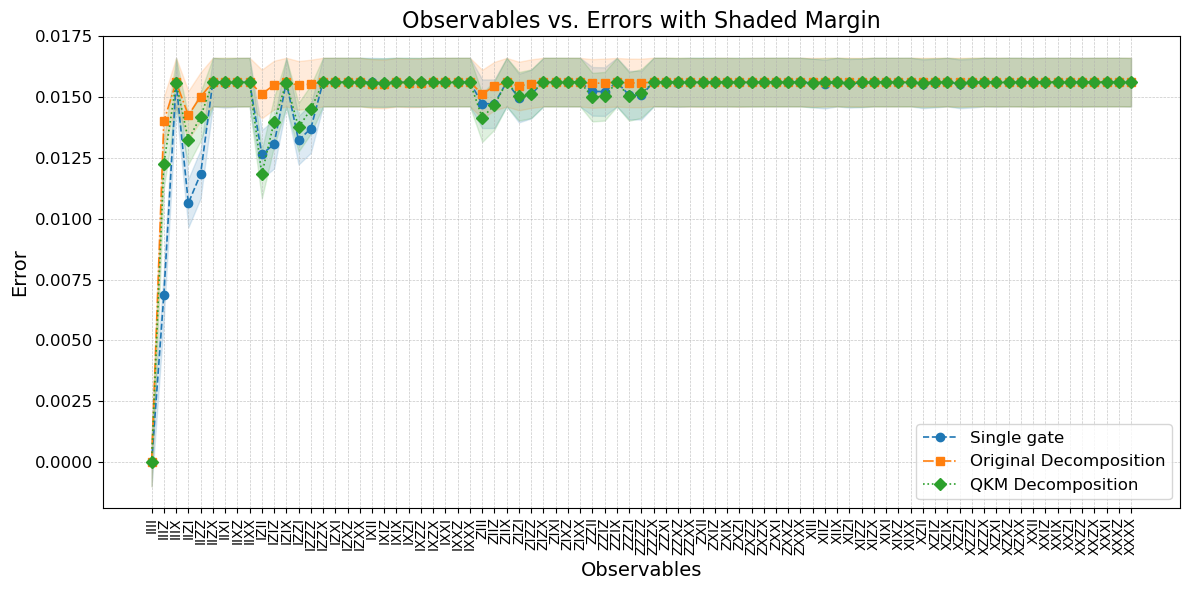

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Larger size for publication

# Plot each set of errors with distinct colors, markers, and line styles
plt.plot(observables_labels, errorsg, 'o--', color='#1f77b4', markersize=6, linewidth=1.2, label='Single gate')
plt.plot(observables_labels, errorsd, 's-.', color='#ff7f0e', markersize=6, linewidth=1.2, label='Original Decomposition')
plt.plot(observables_labels, errorss, 'D:', color='#2ca02c', markersize=6, linewidth=1.2, label='QKM Decomposition')

# Add shaded area (fill between for margin)
plt.fill_between(observables_labels, errorsg - errors_stdg, errorsg + errors_stdg, color='#1f77b4', alpha=0.15)
plt.fill_between(observables_labels, errorsd - errors_stdd, errorsd + errors_stdd, color='#ff7f0e', alpha=0.15)
plt.fill_between(observables_labels, errorss - errors_stds, errorss + errors_stds, color='#2ca02c', alpha=0.15)

# Styling for publication
plt.xlabel('Observables', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Observables vs. Errors with Shaded Margin', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig("c3rx/erro3.png", dpi=300)


# Show the plot
plt.show()

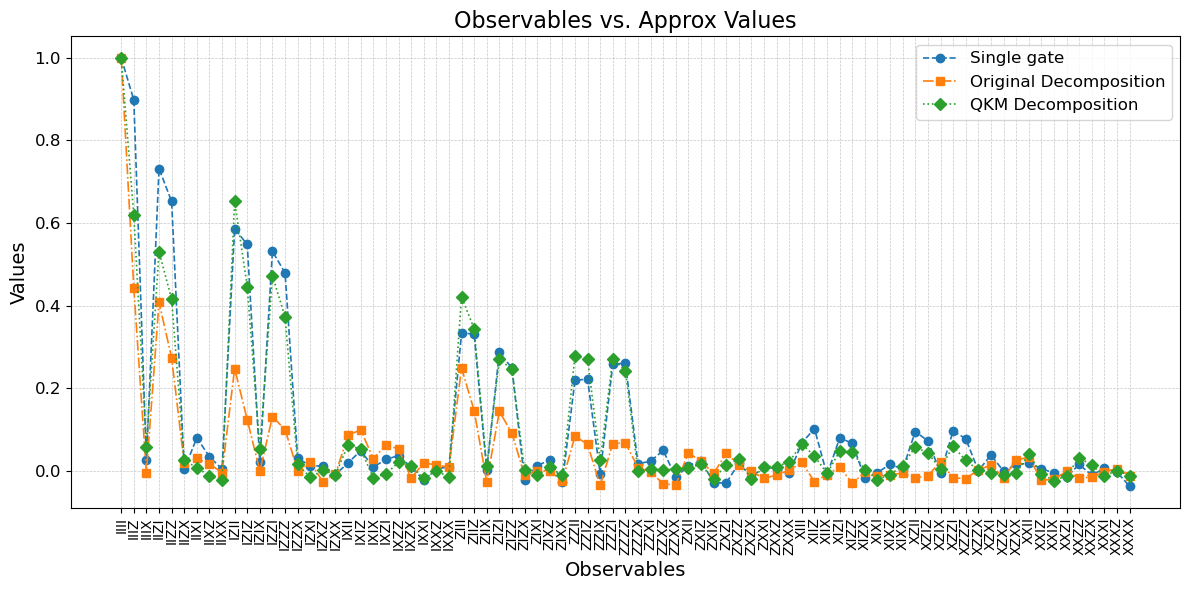

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Larger size for publication

# Plot each set of errors with distinct colors, markers, and line styles
plt.plot(observables_labels, valuesg, 'o--', color='#1f77b4', markersize=6, linewidth=1.2, label='Single gate')
plt.plot(observables_labels, valuesd, 's-.', color='#ff7f0e', markersize=6, linewidth=1.2, label='Original Decomposition')
plt.plot(observables_labels, valuess, 'D:', color='#2ca02c', markersize=6, linewidth=1.2, label='QKM Decomposition')


# Styling for publication
plt.xlabel('Observables', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Observables vs. Approx Values', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig("c3rx/val3.png", dpi=300)

# Show the plot
plt.show()